In [1]:
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def likelihood(x, om, tau, dom):
    return 1/2 + x/2*np.cos(dom * tau + om * tau)

def normal_dist(x, mu, sigma):
    return np.exp(-1/2 * (x - mu)**2 / sigma**2)/np.sum(np.exp(-1/2 * (x - mu)**2 / sigma**2))

def prob_update(x, om, tau, doms, mu_old, sigma_old):
    prob_exact = likelihood(x, om, tau, doms) * normal_dist(doms, mu_old, sigma_old)
    prob_exact /= np.sum(prob_exact)
    mu = np.sum(prob_exact * doms)
    sigma = np.sqrt(np.sum(prob_exact * (doms - mu)**2))
    return prob_exact, mu, sigma

In [41]:
#parameters
dom_grid = np.linspace(-20,20,5001) #grid for dom
initial_sig = 20 #initial standard deviation of dom
initial_mu = 0  #initial average of dom
SHOTS = 20 #numver of shots

#initialization
dom0 = -7   #system frequency detuning to be estimated 
df0 = 2    #controlled detuning 


In [42]:
dom = [dom0]
dfs = []
taus = []
n = 4   #how wide is the filter 

def get_df(sig, mu,n):
    # such that (mu+om)*tau = pi/2, in case of which p(0) = p(1)
    return n*sig/2-mu

def get_tau(sig, n):
    # such that sig*tau = pi/n, and width of the filter is sig
    return np.pi/n/sig

print(n)
dfs.append(get_df(initial_sig,initial_mu,n)) 
taus.append(get_tau(initial_sig,n))

sigs = [initial_sig]
mus = [initial_mu]

prob_exact_reg = [normal_dist(dom_grid, initial_mu, initial_sig)]
prob_approx_reg = [normal_dist(dom_grid, initial_mu, initial_sig)]

for s in range(SHOTS):
    p = likelihood(1,dfs[-1],taus[-1],dom[-1]) #probability p = p(1), p(0) = 1-p
    x = 2 * np.random.choice(2, p = (1-p,p))-1    #measureement 1 or -1

    #update the probability distribution
    prob_exact, mu, sigma = prob_update(x, dfs[-1], taus[-1], dom_grid, mus[-1], sigs[-1])     

    #get next detuning and evolution time:
    dfs.append(get_df(sigma, mu, n))  #controlled detuning 
    taus.append(get_tau(sigma,n)) #evolution time

    #save results
    prob_exact_reg.append(prob_exact)
    prob_gaussian = normal_dist(dom_grid, mu, sigma) #project it into gaussian
    prob_approx_reg.append(prob_gaussian)
    sigs.append(sigma)
    mus.append(mu)



    

4


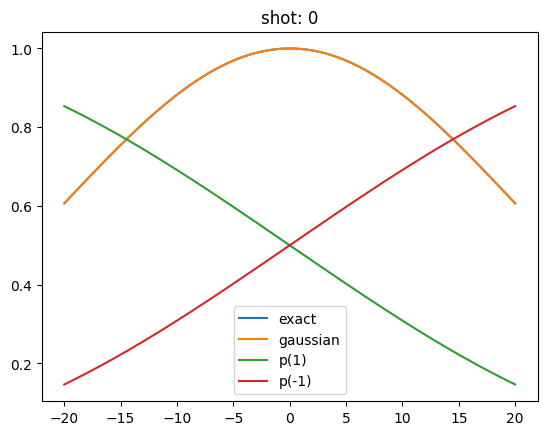

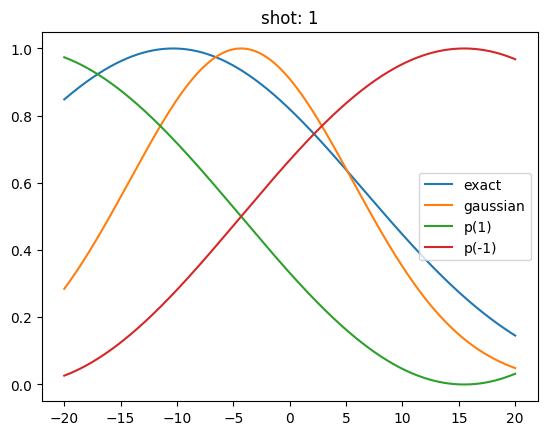

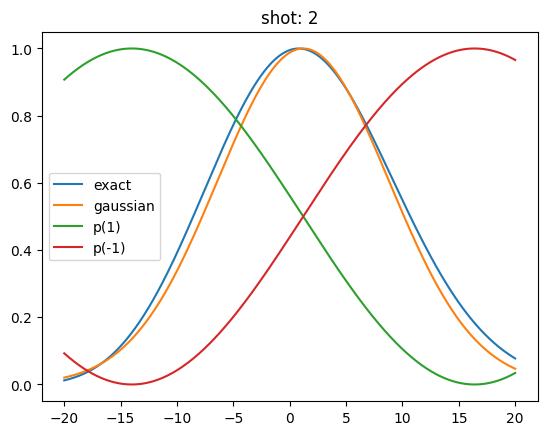

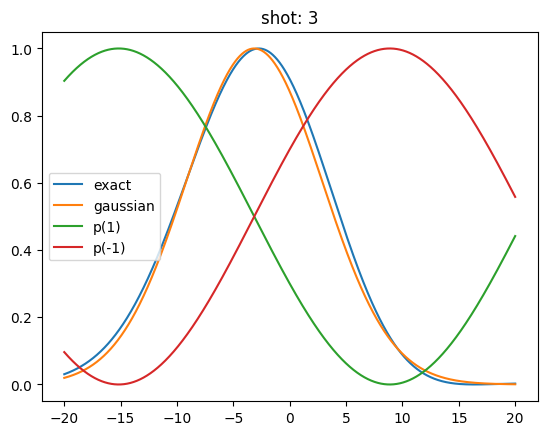

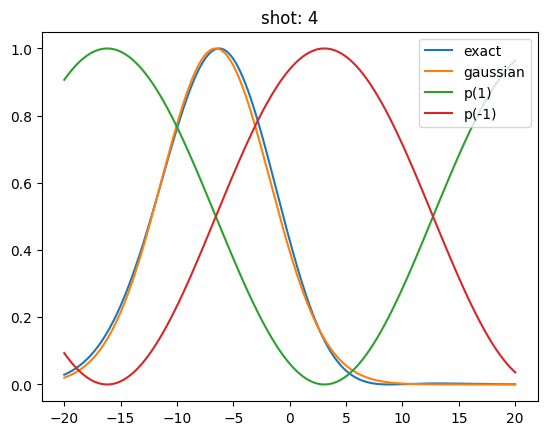

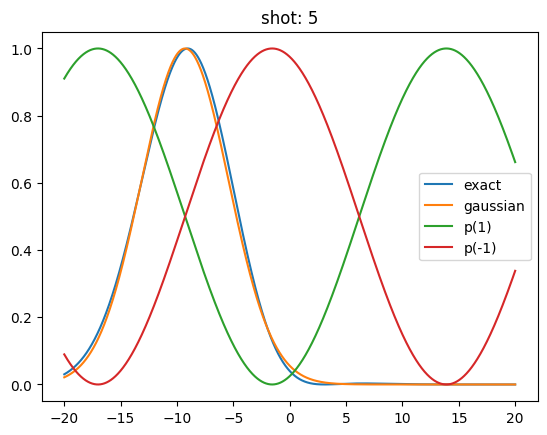

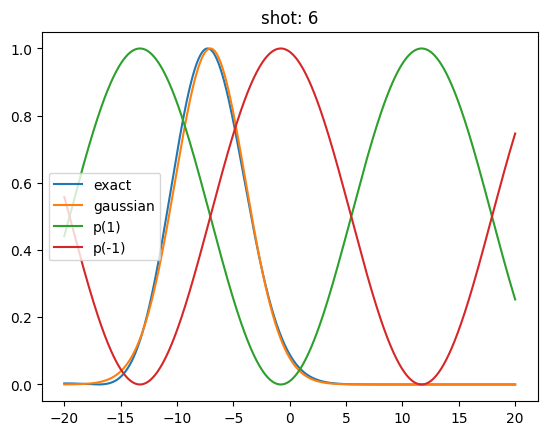

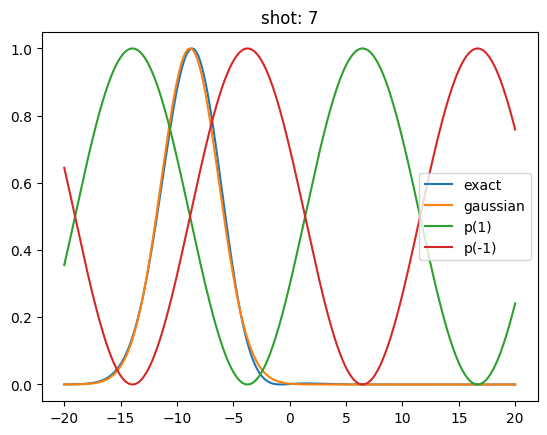

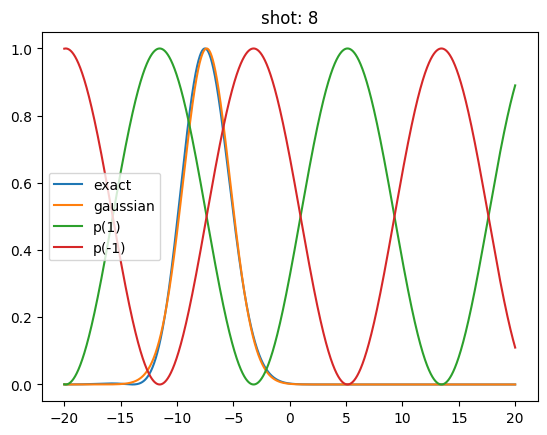

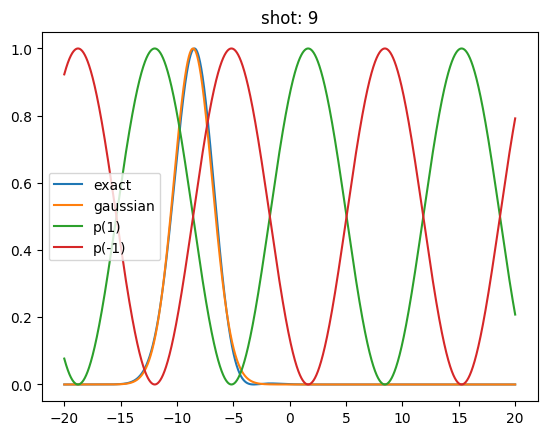

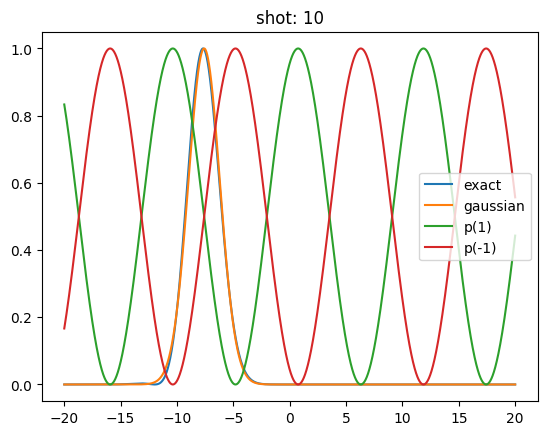

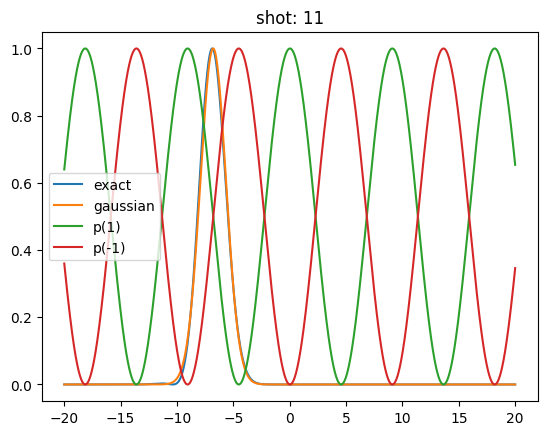

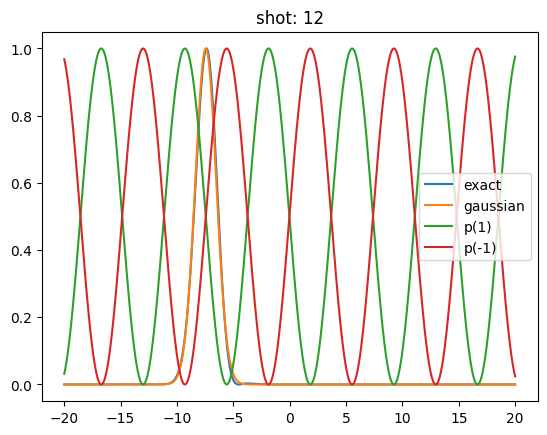

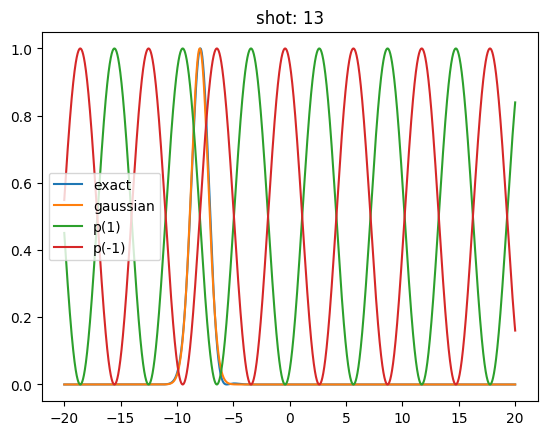

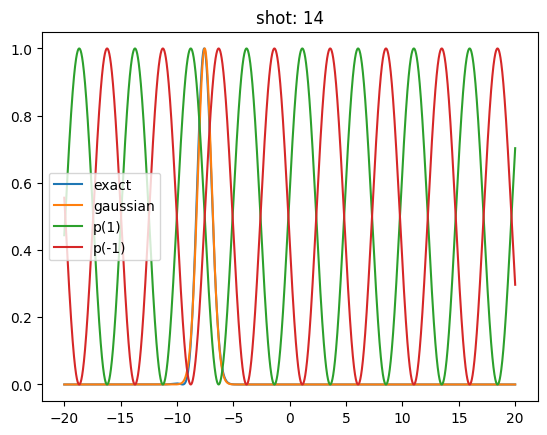

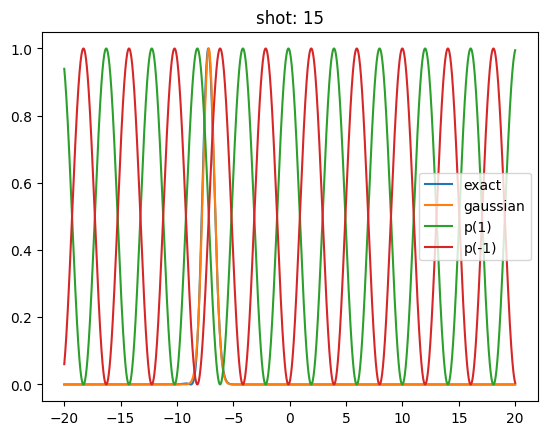

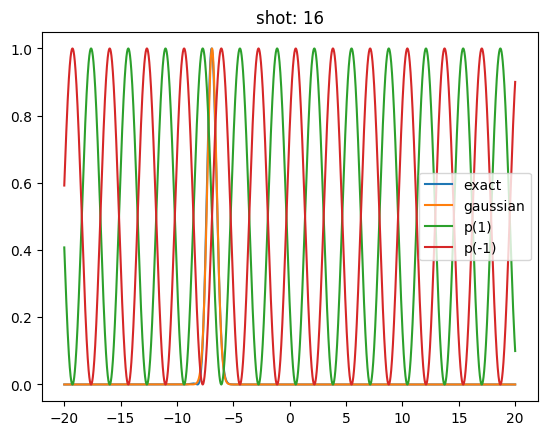

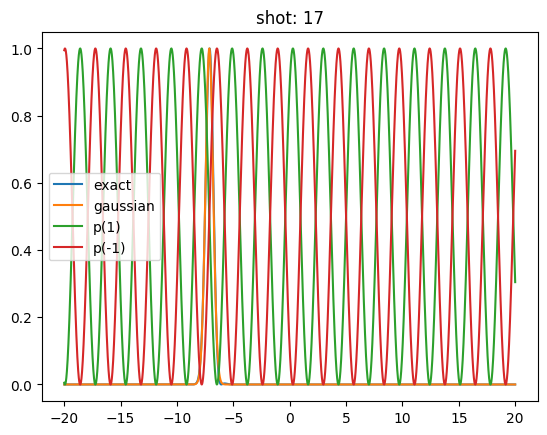

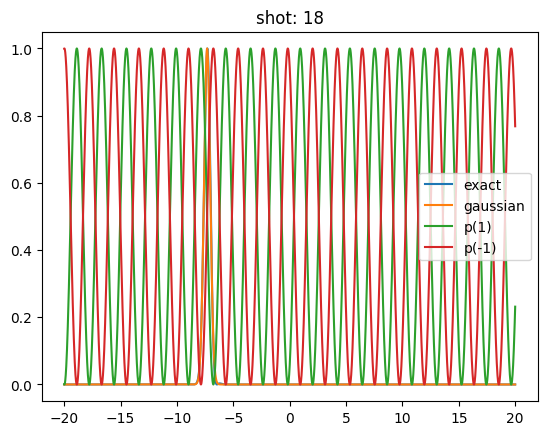

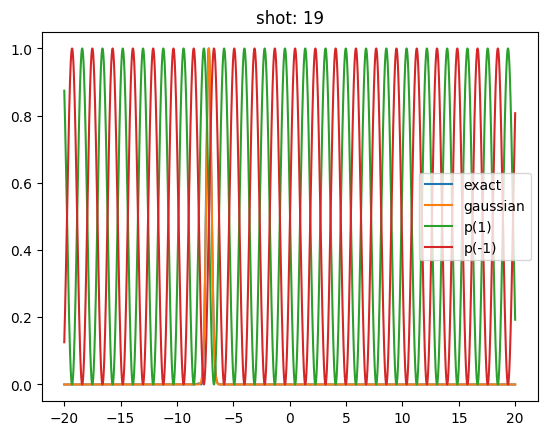

In [43]:
for s in range(SHOTS):
    plt.figure()
    plt.title('shot: '+str(s))
    plt.plot(dom_grid, prob_exact_reg[s]/np.max(prob_exact_reg[s]), label = 'exact')
    plt.plot(dom_grid, prob_approx_reg[s]/np.max(prob_approx_reg[s]), label = 'gaussian')
    plt.plot(dom_grid, likelihood(1,dfs[s],taus[s],dom_grid), label = 'p(1)')
    plt.plot(dom_grid, likelihood(-1,dfs[s],taus[s],dom_grid), label = 'p(-1)')
    plt.legend()
    #useformat with leading zeros 
    plt.savefig('shot_'+str(s).zfill(2)+'.png')
    

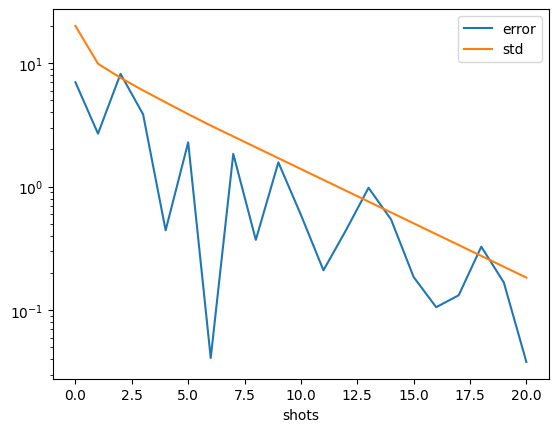

In [49]:
plt.plot(np.abs(np.array(mus)-dom[0]),label="error")
plt.plot(sigs, label="std")
plt.yscale('log')
plt.xlabel("shots")
plt.legend()